In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'
import math
import numpy as np
from pathlib import Path
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D, Softmax, Activation, Reshape, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
[tf.config.experimental.set_memory_growth(gpu, True) for gpu in gpus]

[None]

In [6]:
# hyperparameters
target_size = (128,128,3)
learning_rate = 0.01
momentum = 0.9
weight_decay = 5e-4
batch_size = 16
epochs = 100

In [7]:
l2 = tf.keras.regularizers.l2(l=weight_decay)
def msdu_net():
    input_img = Input(shape=target_size, name='input')
    
    # extractor1/unet1
    e1_out = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', dilation_rate=1, kernel_regularizer=l2, kernel_initializer='he_normal', name='extractor1')(input_img)
    e1_out = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='conv1_1')(e1_out)
    e1_out = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='conv1_2')(e1_out)
    m1_out = MaxPooling2D((2,2), strides=2, name='unet1_3')(e1_out)
    
    # extractor2
    e2_out = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', dilation_rate=2, kernel_regularizer=l2, kernel_initializer='he_normal', name='extractor2')(input_img)
    e2_out = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='conv2_1')(e2_out)
    e2_out = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='conv2_2')(e2_out)
    c2_out = Concatenate(name='concat12')([m1_out, e2_out])
    
    # unet2
    u2_out = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet2_1')(c2_out)
    u2_out = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet2_2')(u2_out)
    m2_out = MaxPooling2D((2,2), strides=2, name='unet2_3')(u2_out)
    
    # extractor3
    e3_out = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', dilation_rate=2, kernel_regularizer=l2, kernel_initializer='he_normal', name='extractor3')(input_img)
    e3_out = Conv2D(filters=128, kernel_size=3, strides=4, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='conv3_1')(e3_out)
    e3_out = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='conv3_2')(e3_out)
    c3_out = Concatenate(name='concat23')([m2_out, e3_out])
    
    # unet3
    u3_out = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet3_1')(c3_out)
    u3_out = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet3_2')(u3_out)
    m3_out = MaxPooling2D((2,2), strides=2, name='unet3_3')(u3_out)
    
    # extractor4
    e4_out = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', dilation_rate=2, kernel_regularizer=l2, kernel_initializer='he_normal', name='extractor4')(input_img)
    e4_out = Conv2D(filters=256, kernel_size=3, strides=8, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='conv4_1')(e4_out)
    e4_out = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='conv4_2')(e4_out)
    c4_out = Concatenate(name='concat34')([m3_out, e4_out])
    
    # unet4
    u4_out = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet4_1')(c4_out)
    u4_out = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet4_2')(u4_out)
    m4_out = MaxPooling2D((2,2), strides=2, name='unet4_3')(u4_out)
    
    # unet5 (bottom)
    u5_out = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet5_1')(m4_out)
    u5_out = Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet5_2')(u5_out)
    u5_out = Conv2DTranspose(filters=512, kernel_size=2, strides=2, padding='same', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet5_3')(u5_out)
    c5_out = Concatenate(name='concat_up45')([u4_out, u5_out])
    
#     # unet6
    u6_out = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet6_1')(c5_out)
    u6_out = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet6_2')(u6_out)
    u6_out = Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding='same', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet6_3')(u6_out)
    c6_out = Concatenate(name='concat_up36')([u3_out, u6_out])
    
    # unet7
    u7_out = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet7_1')(c6_out)
    u7_out = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet7_2')(u7_out)
    u7_out = Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding='same', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet7_3')(u7_out)
    c7_out = Concatenate(name='concat_up27')([u2_out, u7_out])
    
    # unet8
    u8_out = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet8_1')(c7_out)
    u8_out = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet8_2')(u8_out)
    u8_out = Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='same', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet8_3')(u8_out)
    c8_out = Concatenate(name='concat_up18')([e1_out, u8_out])
    
    # unet9
    u9_out = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet9_1')(c8_out)
    u9_out = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2, kernel_initializer='he_normal', name='unet9_2')(u9_out)
    u9_out = Conv2D(filters=1, kernel_size=1, strides=1, padding='same', name='unet9_3')(u9_out)
    u9_out = BatchNormalization(name='unet9_4')(u9_out)
    u9_out = Activation('sigmoid', name='output')(u9_out)
    
    model = Model(inputs=input_img, outputs=u9_out, name='MSDU-NET')
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum), loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

In [9]:
model = msdu_net()
model.summary()

Model: "MSDU-NET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
extractor1 (Conv2D)             (None, 128, 128, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 128, 128, 64) 36928       extractor1[0][0]                 
__________________________________________________________________________________________________
extractor2 (Conv2D)             (None, 128, 128, 32) 896         input[0][0]                      
___________________________________________________________________________________________

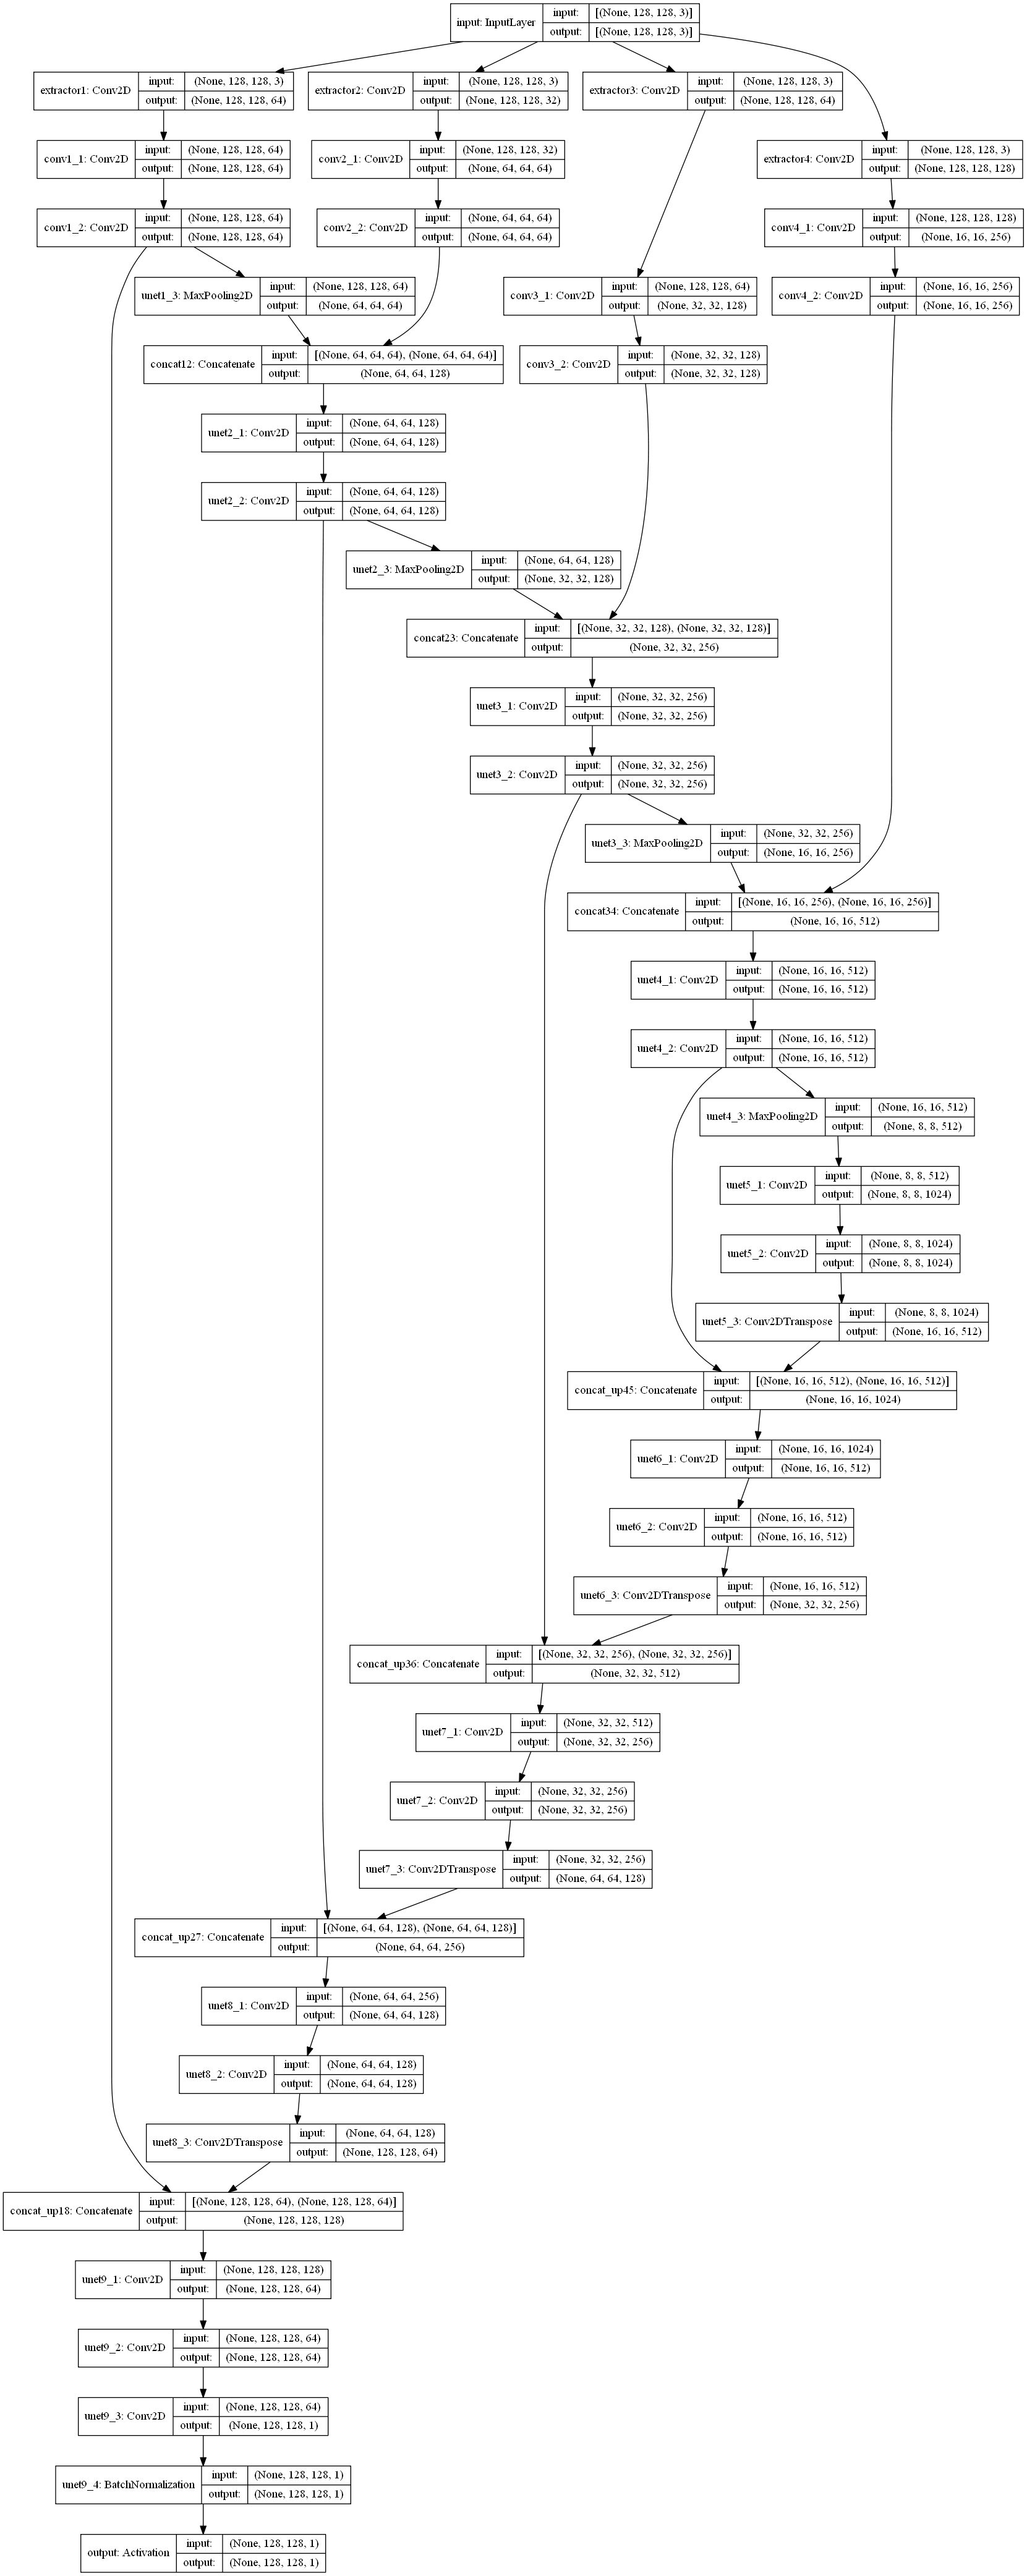

In [10]:
plot_model(model, to_file='msdu-net.png', show_shapes=True)

In [11]:
def normalize_and_contrast(img, mask):
    if (np.max(img) > 1):
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img, mask)

def dataGenerator(batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode="grayscale",
                    mask_color_mode="grayscale", target_size=(256,256), seed=1, shuffle=False):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size
        shuffle = shuffle,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        shuffle = shuffle,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img, mask = normalize_and_contrast(img, mask)
        yield (img, mask)

In [12]:
data_gen_args = dict(rotation_range=10,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
#                     brightness_range=[0.5,1.5],
                    shear_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

train_dir = '../Dataset/Blur/TVT-CUHK-DUT/Training'
val_dir = '../Dataset/Blur/TVT-CUHK-DUT/Test'


train_size = len(list(Path(train_dir).glob('**/*.png')))
val_size = len(list(Path(val_dir).glob('**/*.png')))
print(train_size, val_size)


train_data = dataGenerator(batch_size,
                            train_dir,
                            'image',
                            'gt',
                            data_gen_args,
                            image_color_mode='rgb',
                            target_size=target_size[:2],
                            shuffle=True)

val_data = dataGenerator(batch_size,
                          val_dir,
                          'image',
                          'gt',
                          dict(),
                          image_color_mode='rgb',
                          target_size=target_size[:2],
                          shuffle=False)

1400 700


In [13]:
def decay(epoch, lr):
    return lr * 0.1 if (epoch % 25 == 0) and epoch != 0 else lr

In [14]:
model_checkpoint = ModelCheckpoint('ckpt-msdu-net-tvt.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

lr_schedule = LearningRateScheduler(decay, verbose=1)

history = model.fit_generator(train_data,
                              steps_per_epoch=math.ceil(train_size/batch_size),
                              epochs=epochs,
                              verbose=1,
                              validation_data=val_data,
                              validation_steps=math.ceil(val_size/batch_size),
                              callbacks=[model_checkpoint, lr_schedule])

C:\Users\Solorist\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1876: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 1400 images belonging to 1 classes.
Found 1400 images belonging to 1 classes.
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
88/88 [==============================] - ETA: 0s - loss: 9.6188 - binary_accuracy: 0.6358Found 700 images belonging to 1 classes.
Found 700 images belonging to 1 classes.
88/88 [==============================] - 27s 214ms/step - loss: 9.6177 - binary_accuracy: 0.6365 - val_loss: 9.4731 - val_binary_accuracy: 0.7214

Epoch 00001: val_loss improved from inf to 9.47315, saving model to ckpt-msdu-net-tvt.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
88/88 [==============================] - 14s 157ms/step - loss: 9.3296 - binary_accuracy: 0.7523 - val_loss: 9.1930 - val_binary_accuracy: 0.7833

Epoch 00002: val_loss improved from 9.47315 to 9.19299, saving model to ckpt-msdu-net-tvt.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0


Epoch 00024: val_loss improved from 6.44967 to 6.27174, saving model to ckpt-msdu-net-tvt.h5
Epoch 25/100

Epoch 00025: LearningRateScheduler reducing learning rate to 0.009999999776482582.
88/88 [==============================] - 15s 174ms/step - loss: 6.2569 - binary_accuracy: 0.8312 - val_loss: 6.1305 - val_binary_accuracy: 0.8560

Epoch 00025: val_loss improved from 6.27174 to 6.13053, saving model to ckpt-msdu-net-tvt.h5
Epoch 26/100

Epoch 00026: LearningRateScheduler reducing learning rate to 0.0009999999776482583.
88/88 [==============================] - 15s 176ms/step - loss: 6.1488 - binary_accuracy: 0.8450 - val_loss: 6.1208 - val_binary_accuracy: 0.8549

Epoch 00026: val_loss improved from 6.13053 to 6.12084, saving model to ckpt-msdu-net-tvt.h5
Epoch 27/100

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0009999999310821295.
88/88 [==============================] - 15s 176ms/step - loss: 6.1430 - binary_accuracy: 0.8388 - val_loss: 6.1013 - val_binary_accu

88/88 [==============================] - 20s 232ms/step - loss: 5.8950 - binary_accuracy: 0.8530 - val_loss: 5.9135 - val_binary_accuracy: 0.8399

Epoch 00050: val_loss did not improve from 5.88268
Epoch 51/100

Epoch 00051: LearningRateScheduler reducing learning rate to 9.999999310821295e-05.
88/88 [==============================] - 20s 232ms/step - loss: 5.9018 - binary_accuracy: 0.8475 - val_loss: 5.8784 - val_binary_accuracy: 0.8559

Epoch 00051: val_loss improved from 5.88268 to 5.87842, saving model to ckpt-msdu-net-tvt.h5
Epoch 52/100

Epoch 00052: LearningRateScheduler reducing learning rate to 9.99999901978299e-05.
88/88 [==============================] - 21s 236ms/step - loss: 5.8753 - binary_accuracy: 0.8564 - val_loss: 5.8665 - val_binary_accuracy: 0.8619

Epoch 00052: val_loss improved from 5.87842 to 5.86652, saving model to ckpt-msdu-net-tvt.h5
Epoch 53/100

Epoch 00053: LearningRateScheduler reducing learning rate to 9.99999901978299e-05.
88/88 [=======================

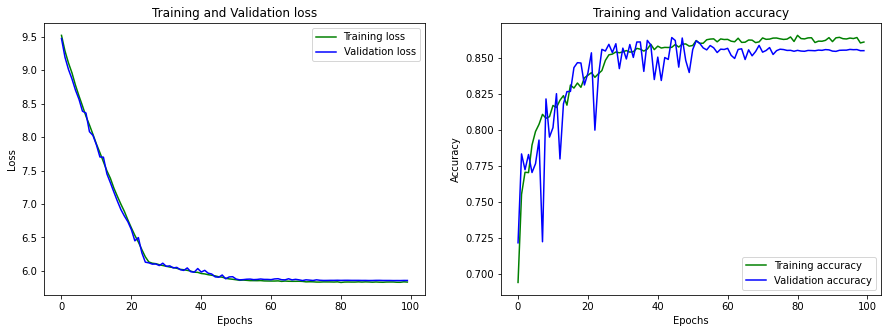

In [15]:
# Result Visualization
loss_train = history.history['loss']
loss_val = history.history['val_loss']

acc_train = history.history['binary_accuracy']
acc_val = history.history['val_binary_accuracy']

epochs_ax = history.epoch

plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(epochs_ax, loss_train, 'g', label='Training loss')
plt.plot(epochs_ax, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Visualization
ax = plt.subplot(1, 2, 2)
plt.plot(epochs_ax, acc_train, 'g', label='Training accuracy')
plt.plot(epochs_ax, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('History.png')
plt.show()

In [ ]:
saved_name = 'MSDU_Net_K+_100E_No_last_l2_Ratio_Preserved_CUHK_DUT.h5'

if not os.path.exists(saved_name):
    model.save(saved_name)
    print(saved_name, 'saved')
else:
    print(saved_name, 'exists')

In [ ]:
count = 0

# Val by batch

In [ ]:
val_data = trainGenerator(batch_size,
                          val_dir,
                          'image',
                          'gt',
                          dict(),
                          image_color_mode='rgb',
                          target_size=target_size[:2],
                          shuffle=False)

In [ ]:
for data in val_data:
    print(count)
    if count >= val_size:
        break
    test_imgs, labels = data
    res = model.predict(test_imgs)
    res = np.asarray(res)
    res = res.reshape([res.shape[0]]+list(target_size[:2]))
    labels = labels.reshape([res.shape[0]]+list(target_size[:2]))
#     print(labels.shape)
    length = res.shape[0]
    fig = plt.figure(figsize=(5*3,5*length))
    for i in range(len(res)):
        ax = plt.subplot(length,3,3*i+1)
        ax.set_title('Original')
        ax.set_axis_off()
        plt.imshow(test_imgs[i])
        # save image
        img = Image.fromarray((test_imgs[i] * 255.).astype(np.uint8))
        img.save(os.path.join('../Predicted/Blur/image/',str(count)+'.png'), 'PNG')    

        ax = plt.subplot(length,3,3*i+2)
        ax.set_title('Predicted')
        ax.set_axis_off()
        plt.imshow(res[i], cmap='gray')
        # save predicted
        predicted_img = Image.fromarray((res[i] * 255.).astype(np.uint8))
        predicted_img.save(os.path.join('../Predicted/Blur/predicted/',str(count)+'.png'), 'PNG')

        ax = plt.subplot(length,3,3*i+3)
        ax.set_title('Ground Truth')
        ax.set_axis_off()
        plt.imshow(labels[i], cmap='gray')
        # save gt
        gt_img = Image.fromarray((labels[i] * 255.).astype(np.uint8))
        gt_img.save(os.path.join('../Predicted/Blur/gt/',str(count)+'.png'), 'PNG')

        count += 1
    plt.show()